# I am going to be using machine learning to predict the prices of houses in California.

The idea is to train a model which will predict a house price given where the house is located, the number of rooms it has etc.
This is my first machine learning task.

To determine how well my model performs, I am going to use the root mean square error (RMSE) to determine the error between the actual and predicted house prices. The lower the RMSE the better my model is at predicting housing prices in California.

#### This project was done with the help of the "Hands-on Machine Learning with Scikit-Learn and Tensorflow" book to teach me Machine learning.

In [104]:
#Importing the neccessary packages
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import hashlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
import scipy as sc
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV





In [38]:
#Taken from https://github.com/scikit-learn/scikit-learn/blob/34155a2/sklearn/preprocessing/data.py#L2869 to help with the 
#project.
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot (aka one-of-K or dummy)
    encoding scheme (``encoding='onehot'``, the default) or converted
    to ordinal integers (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.
        The used categories can be found in the ``categories_`` attribute.
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).
    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.
        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.
        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.
        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
                and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

## Downloading the data

In [6]:
#Downloading the data
#Writing a small function to read in the data.
download_root = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/"
housing_path = os.path.join("datasets", "housing")
housing_url = download_root + "housing.tgz"

#Defining a function to collect the data from the above URL.
#Creating this function so it's easier to read in the dataset again if it was to change.

def fetch_housing_data(housing_url = housing_url, housing_path = housing_path):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

def load_housing_data(housing_path = housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)




## Getting an idea for what the dataset looks like

In [7]:
#Getting an idea for what the dataset looks like.
fetch_housing_data()
housing_data = load_housing_data()
housing_data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing_data.info()
housing_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Notice how there are some missing values for total_bedrooms. We need to deal with this missing data soon.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253D49F32E8>,
      dtype=object)

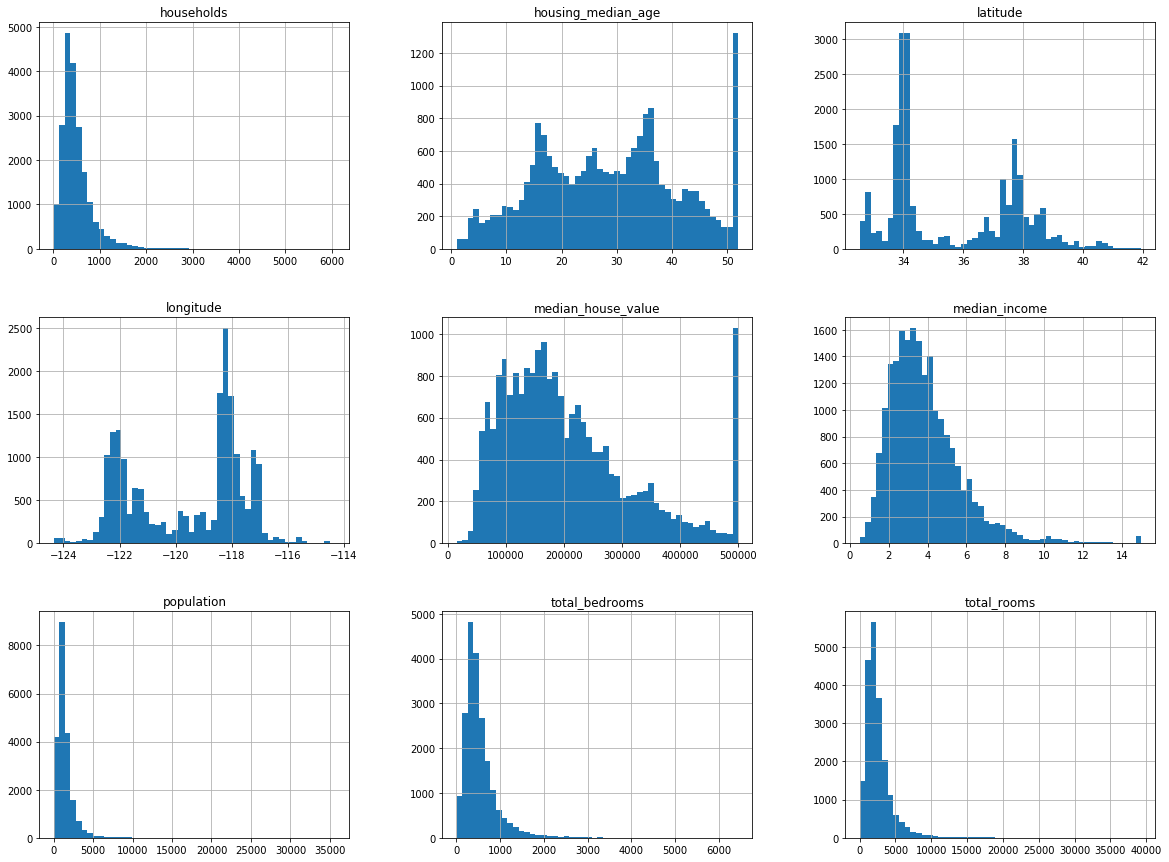

In [9]:
housing_data.hist(bins = 50, figsize = (20,15))

Here we can see histograms of where our data lies.

A few things to note:
- Both median_house_value and housing_median_age have been capped at certain values. This explains the unusual peaks in the histograms.
- The histograms extend much further to the right of the median. This will make it more difficult to create an accurate model for the housing prices.

## Creating training and test sets

We use the training set to train our model for the data. Then we use the test set on the model to see how well it performed.

In [65]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_data, test_size = 0.2, random_state = 42)

print("The length of my train set is: " + str(len(train_set)))
print("The length of my test set is: " + str(len(test_set)))
train_set.head(3)

The length of my train set is: 16512
The length of my test set is: 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN


In this function it splits the orginal data set into two subsets, training and testing. It's also important to note that the data was shuffled as the data could have been ordered when it was made. Say for example we split the data in a way so that all northern California homes were in the training set and all southern California homes were in the test set. The model would perform well on the training but horribly on the test set.

It is important to note that everytime this function is called, each subset is changed.

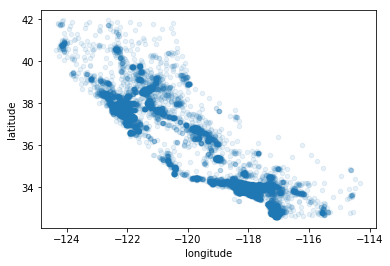

In [50]:
train_set.plot(kind="scatter", x = "longitude", y = "latitude", alpha = 0.1)

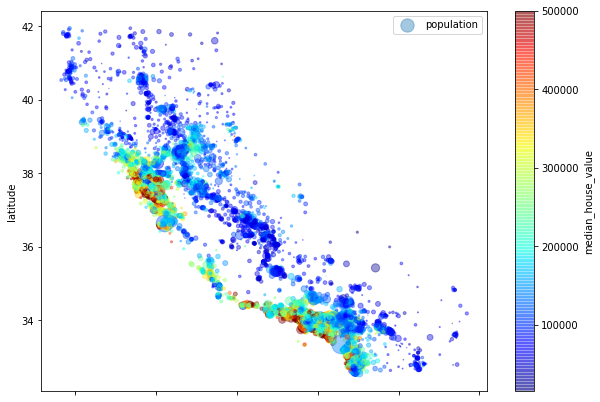

In [51]:
train_set.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
              s = train_set["population"]/100, label = "population", figsize=(10,7),
               c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar=True)
plt.legend()

# Preparing the Data for Machine Learning Algorithms


In [68]:
median = train_set["total_bedrooms"].median()
train_set["total_bedrooms"].fillna(median, inplace = True)

housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()


C:\Nikhil\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


For Machine Learning Algorithms, they tend to not like missing values (N/A's). For all the missing values, I have replaced them with the median for that column.

Next we are factorising text values in the dataset

In [74]:
housing_cat = housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:6]
housing_cat.head(5)

14196    NEAR OCEAN
8267     NEAR OCEAN
17445    NEAR OCEAN
14265    NEAR OCEAN
2271         INLAND
Name: ocean_proximity, dtype: object

## One Hot Encoding

We use one hot encoding for an important reason. In the Machine Learning process, it will assume that nearby values are more similar than further distanced values. This is not the case if you were factorising categories. One hot encoding solves this issue.

### What is One Hot Encoding?

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. 

In [75]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [76]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix]/X[:, household_ix]
        population_per_household = X[:, bedrooms_ix,]/X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [77]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [78]:
housing_num = housing.drop("ocean_proximity", axis = 1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([("selector", DataFrameSelector(num_attribs)), ("imputer", Imputer(strategy = "median")),
                         ("attribs_adder", CombinedAttributesAdder()), ("std_scaler", StandardScaler())])
cat_pipeline = Pipeline([("selector", DataFrameSelector(cat_attribs)), ("cat_encoder", CategoricalEncoder(encoding = "onehot-dense"))])

In [79]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list = [("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline)])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [80]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("labels:", list(some_labels))

Predictions: [181886.19716369 290384.11320733 244869.43422738 146568.39490889
 163225.57136809]
labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


# The model in action

In [82]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Root mean squared error is:", lin_rmse)

Root mean squared error is: 67597.0994001535


A root mean squared error of 67597 is ok, but not a great score. As the RMSE is high, this is an example of our model underfitting the training data. Now we will focus on editing our model by improving the fit and in theory getting a lower RMSE. Once I am happy with the error, we can use this model to test it on our test data.

# Using a different model

Here we are going to use a decision tree to see if it fits our model better.

In [84]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [88]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

At first glance this may seem perfect, we have created a model which perfectly predicts the housing prices. However this is not the case. This is an example of overfitting. This means that we have made a model perfect for our training set but if we were to use this in the real world, it would perform poorly.

A way to test this is by splitting up the training set further into a training set and validation set.

In [91]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([68229.68480374, 69056.18719733, 72487.58008062, 71194.58000582,
       73250.52795351, 70500.05697757, 64603.74999035, 71887.93625304,
       68333.12999062, 70422.9078059 ])

In [93]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [68229.68480374 69056.18719733 72487.58008062 71194.58000582
 73250.52795351 70500.05697757 64603.74999035 71887.93625304
 68333.12999062 70422.9078059 ]
Mean: 69996.63410584831
Standard deviation: 2410.3293201559854


What we have done here is split up the training set into 10 random subsets called folds, then we trained the model with 1 fold and evaluate the decison tree on the other 9 folds, this is repeated for every fold.

Let's do the same with the Linear Regression to make sure


In [95]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65003.12950666 70945.85532919 67140.94269322 66087.59602821
 68415.40208388 64754.79845522 65233.38691323 68532.91928423
 72751.46689664 68955.71176545]
Mean: 67782.12089559271
Standard deviation: 2524.118009960755


## Trying another different model

In [98]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [101]:
housing_predicitons = forest_reg.predict(housing_prepared)
random_forest_mse = mean_squared_error(housing_predicitons, housing_labels)
random_forest_rmse = np.sqrt(random_forest_mse)
random_forest_rmse


22122.60262582207

This is low. Let's use our previous method to see whether the model if overfitting the training data.

In [103]:
rf_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores: [50309.79805678 52912.57604346 50976.13034573 53774.80019778
 53037.85097227 49276.43315465 49425.72848817 53649.0731921
 51384.75521081 52181.3821782 ]
Mean: 51692.85278399362
Standard deviation: 1587.3594800294077


This shows that the first random forest model was overfitting the data. This new mean and standard deviation shows a more accurate representation of the model. 

This model does significantly better than the linear regression and the decision tree scores.

### RMSE scores so far:

- Linear Regression: 67782.120
- Decision Tree: 69996.634
- Random Forest: 51692.853

In practise we should test our data on many different models to short list a number of them who do well.

The model is stil overfitting our training set as it's value is higher than the validation set. Now we need to think of solutions to not make our model overfit.

# Fine-tune my model

In [105]:
param_grid = [{"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8], "bootstrap": [False], "n_estimators": [3, 10], 
              "max_features": [2, 3, 4]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = "neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)